In [2]:
using CSV
using DataFrames
using Printf
using DelimitedFiles
import PyPlot; const plt = PyPlot # now do plt.plt[:hist] for example
using MultivariateStats
using Optim

In [7]:
list_of_isotherms = readdlm("so2_co2_list.txt")

26×1 Array{Any,2}:
 "Co-CN6-CO2_298.csv"       
 "Co-CN6-SO2_298.csv"       
 "MFM-300-In-CO2_298.csv"   
 "MFM-300-In-SO2_298.csv"   
 "MFM600-CO2_298.csv"       
 "MFM600-SO2_298.csv"       
 "MFM601-CO2_298.csv"       
 "MFM601-SO2_298.csv"       
 "Ni-bdc-ted-CO2_298.csv"   
 "Ni-bdc-ted-SO2_298.csv"   
 "NOTT-202a-CO2_293.csv"    
 "NOTT-202a-SO2_293.csv"    
 "NOTT-300-CO2_293.csv"     
 "NOTT-300-SO2_293.csv"     
 "SIFSIX-1-Cu-CO2_298.csv"  
 "SIFSIX-1-Cu-SO2_298.csv"  
 "SIFSIX-2-Cu-i-CO2_298.csv"
 "SIFSIX-2-Cu-i-SO2_298.csv"
 "SIFSIX-3-Ni-CO2_298.csv"  
 "SIFSIX-3-Ni-SO2_298.csv"  
 "SIFSIX-3-Zn-CO2_298.csv"  
 "SIFSIX-3-Zn-SO2_298.csv"  
 "Zn-bdc-ted-CO2_298.csv"   
 "Zn-bdc-ted-SO2_298.csv"   
 "Zn-CN6-CO2_298.csv"       
 "Zn-CN6-SO2_298.csv"       

In [9]:
function read_and_convert(isotherm_file::AbstractString)
    @printf("Working on file %s\n", isotherm_file)
    isotherm = CSV.read("../data/expt_data/SO2_CO2/" * isotherm_file)
    pUnit, aUnit = string.(names(isotherm))
    P0 = 0.03169 #bar
    Vp = 0.63 #cm3/g
    
    if pUnit == "Pressure(bar)"
        @printf("Pressure unit is already in bar\n")
    elseif pUnit == "Pressure(torr)"
        isotherm[1] = isotherm[1] ./ 750.06
        @printf("Converting pressure unit from torr to bar\n")
    elseif pUnit == "Pressure(kPa)"
        isotherm[1] = isotherm[1] ./ 100.0
        @printf("Converting pressure unit from kPa to bar\n")
    elseif pUnit == "Pressure(P/P0)"
        isotherm[1] = isotherm[1] .* P0
        @printf("Converting pressure unit from P/P0 to bar")
    else
        @printf("WHAT? P\n")
    end
    names!(isotherm, [Symbol("Pressure(bar)"), names(isotherm)[2]])
            
    MW_CO2 = 44.01
    if aUnit == "Adsorption(mmol/g)"
        @printf("Adsorption unit is already in mmol/g\n")
    elseif aUnit == "Adsorption(mg/g)"
        isotherm[2] = isotherm[2] ./ MW_CO2
        @printf("Converting adsorption unit from mg/g to mmol/g\n")
    elseif aUnit == "Adsorption(cm3(STP)/g)"
        isotherm[2] = isotherm[2] ./ 22.4
        @printf("Converting adsorption unit from cm3(STP)/g to mmol/g\n")
    elseif aUnit == "Adsorption(mmol/cm3)"
        isotherm[2] = isotherm[2] .* Vp
        @printf("Converting adsorption unit from mmol/cm3 to mmol/g")
    else
        @printf("WHAT? A\n")
    end
    names!(isotherm, [names(isotherm)[1], Symbol("Adsorption(mmol/g)")])
    return isotherm
end

read_and_convert (generic function with 1 method)

In [5]:
function fit_henry(df_ads::DataFrame, incl_nb_pts::Int)
    # sort by pressure
    sort!(df_ads, [Symbol("Pressure(bar)")])
    # build feature matrix
    P = zeros(incl_nb_pts, 1)
    n = zeros(incl_nb_pts)
    for (i, row) in enumerate(eachrow(df_ads))
        if i > incl_nb_pts
            break
        end
        P[i, 1] = row[Symbol("Pressure(bar)")]
        n[i] = row[Symbol("Adsorption(mmol/g)")]
    end
    # fit line without bias (henry coef) to determine henry coefficient
    K = llsq(P, n; bias=false)[1]
    return K # mmol/(g-bar)
end

fit_henry (generic function with 1 method)

In [15]:
nb_pts_to_incl_in_fitting = Dict{AbstractString, Int64}()
nb_pts_to_incl_in_fitting["Co-CN6-CO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["Co-CN6-SO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["MFM-300-In-CO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["MFM-300-In-SO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["MFM600-CO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["MFM600-SO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["MFM601-CO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["MFM601-SO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["Ni-bdc-ted-CO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["Ni-bdc-ted-SO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["NOTT-202a-CO2_293.csv"] = 2
nb_pts_to_incl_in_fitting["NOTT-202a-SO2_293.csv"] = 2
nb_pts_to_incl_in_fitting["NOTT-300-CO2_293.csv"] = 2
nb_pts_to_incl_in_fitting["NOTT-300-SO2_293.csv"] = 2
nb_pts_to_incl_in_fitting["SIFSIX-1-Cu-CO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["SIFSIX-1-Cu-SO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["SIFSIX-2-Cu-i-CO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["SIFSIX-2-Cu-i-SO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["SIFSIX-3-Ni-CO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["SIFSIX-3-Ni-SO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["SIFSIX-3-Zn-CO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["SIFSIX-3-Zn-SO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["Zn-bdc-ted-CO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["Zn-bdc-ted-SO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["Zn-CN6-CO2_298.csv"] = 2
nb_pts_to_incl_in_fitting["Zn-CN6-SO2_298.csv"] = 2

2

In [11]:
nb_pts_to_incl_in_fitting = Dict{AbstractString, Int64}()
nb_pts_to_incl_in_fitting["Al-MIL-53_304K.csv"] = 2
nb_pts_to_incl_in_fitting["MIL-101_303K.csv"] = 3
nb_pts_to_incl_in_fitting["MIL-101-NH2_293K.csv"] = 3
nb_pts_to_incl_in_fitting["MIL-101-NO2_293K.csv"] = 3
nb_pts_to_incl_in_fitting["MIL-125_298K.csv"] = 10
nb_pts_to_incl_in_fitting["MIL-125-NH2_298K.csv"] = 10
nb_pts_to_incl_in_fitting["MIL-68_298K.csv"] = 5
nb_pts_to_incl_in_fitting["MIL-68-NH2_298K.csv"] =3 
nb_pts_to_incl_in_fitting["SIM-1_303K.csv"] = 2
nb_pts_to_incl_in_fitting["ZIF-8_298K.csv"] = 3
nb_pts_to_incl_in_fitting["MCM-41-water_298K.csv"] = 8
nb_pts_to_incl_in_fitting["MCM-41_298K.csv"] = 5

5

Working on file Co-CN6-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Working on file Co-CN6-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Working on file MFM-300-In-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Working on file MFM-300-In-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Working on file MFM600-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Working on file MFM600-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Working on file MFM601-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Working on file MFM601-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Working on file Ni-bdc-ted-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Working on file Ni-bdc-ted-SO2_298.csv
Pressure unit

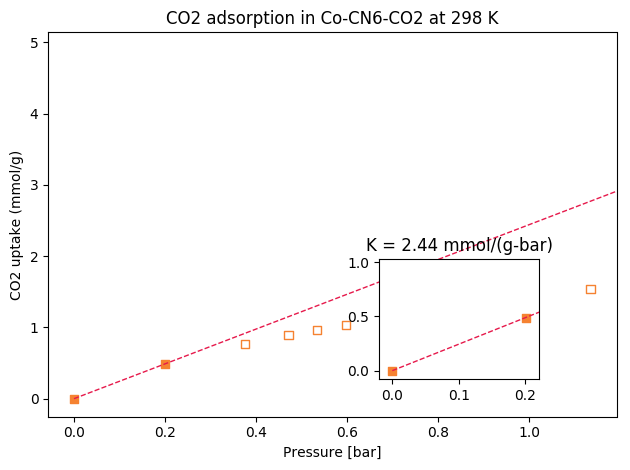

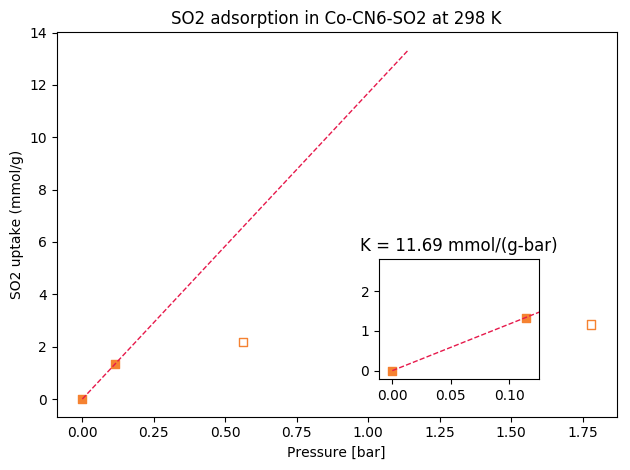

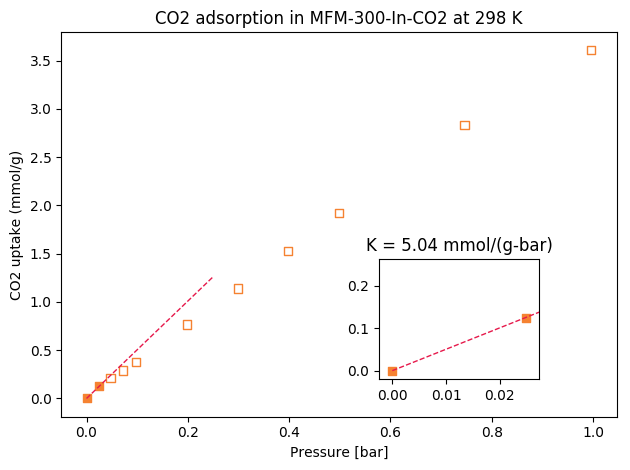

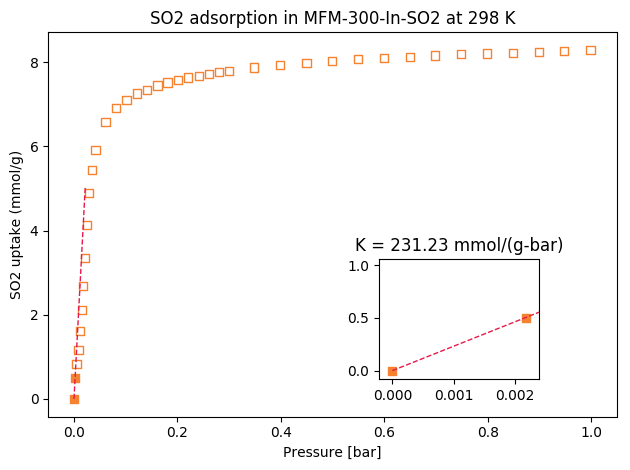

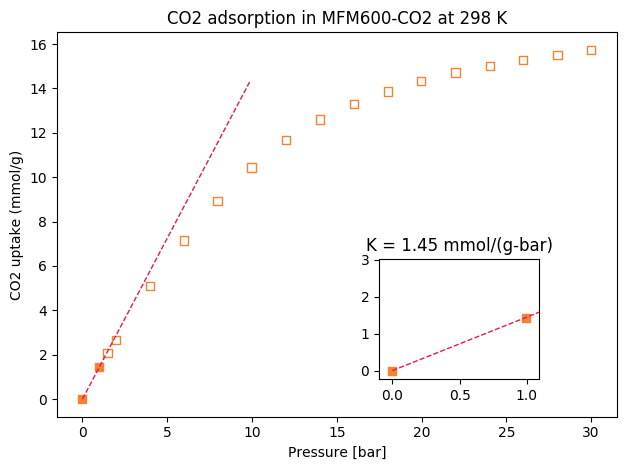

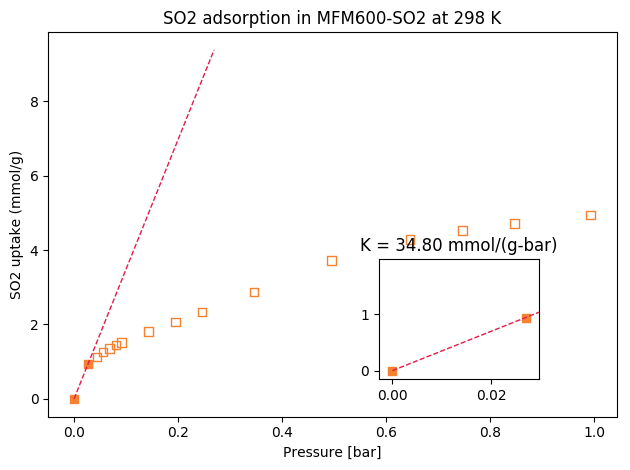

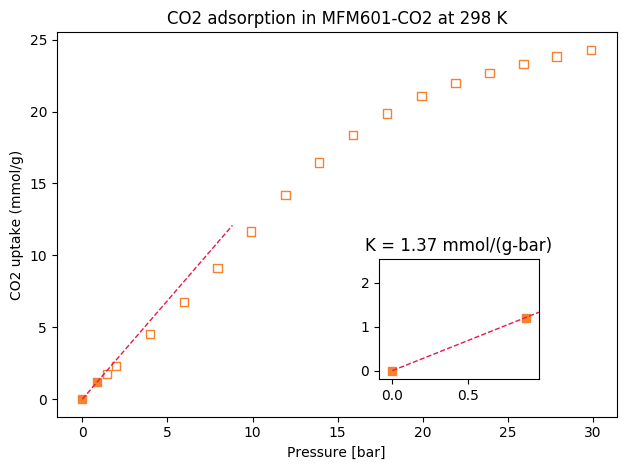

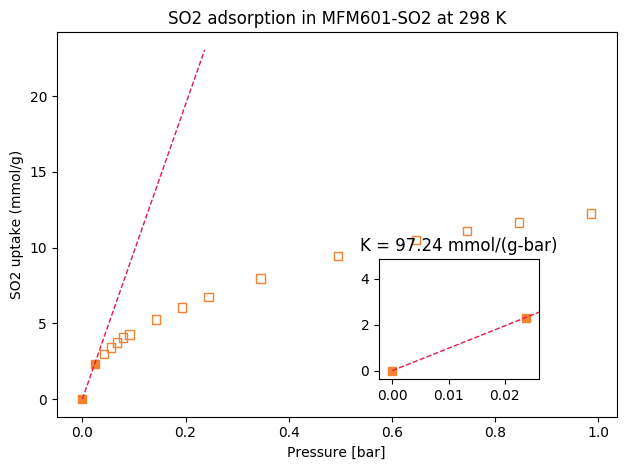

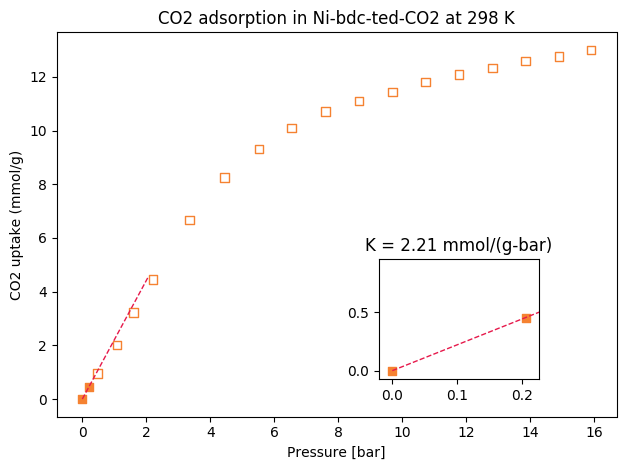

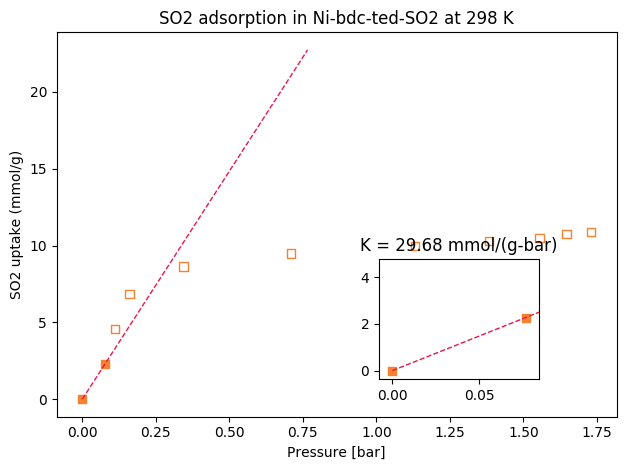

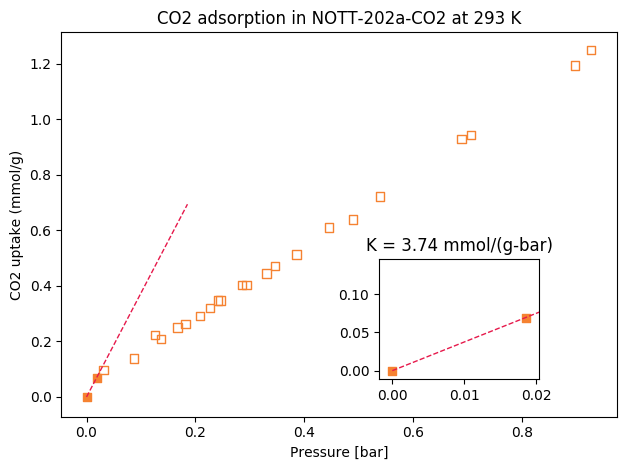

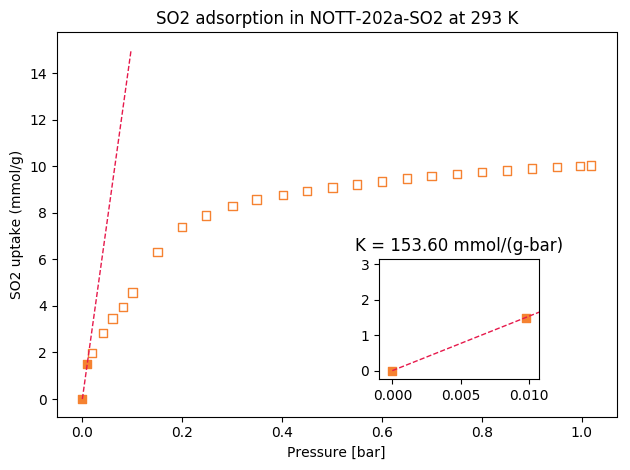

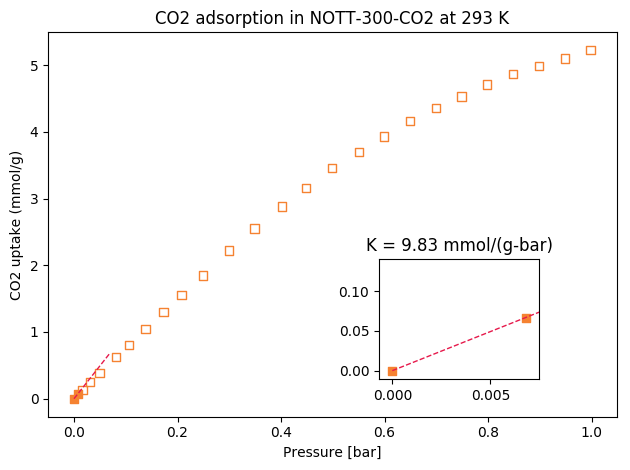

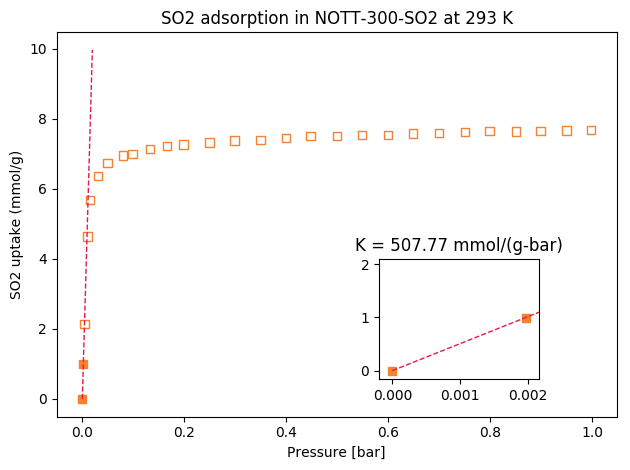

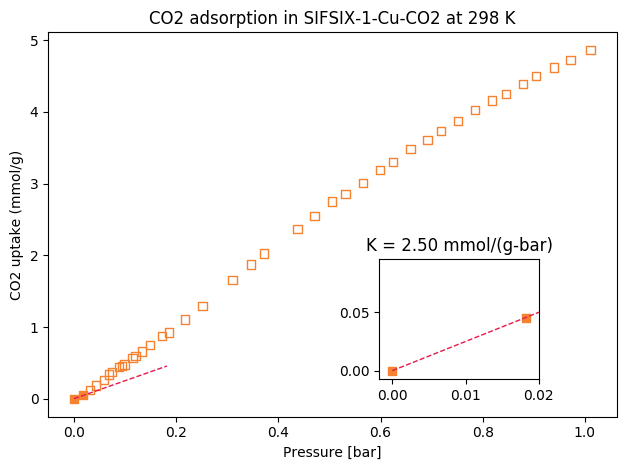

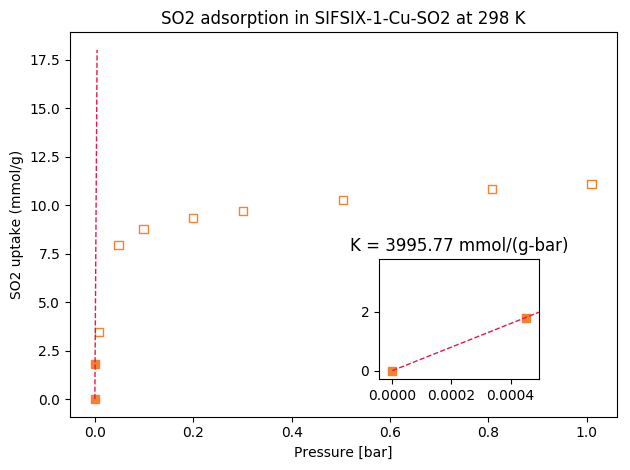

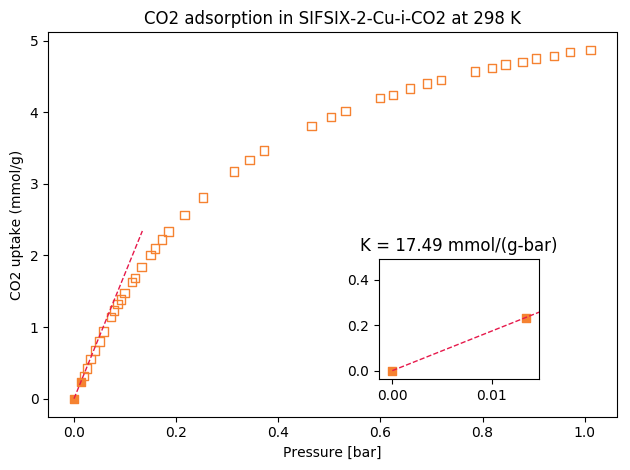

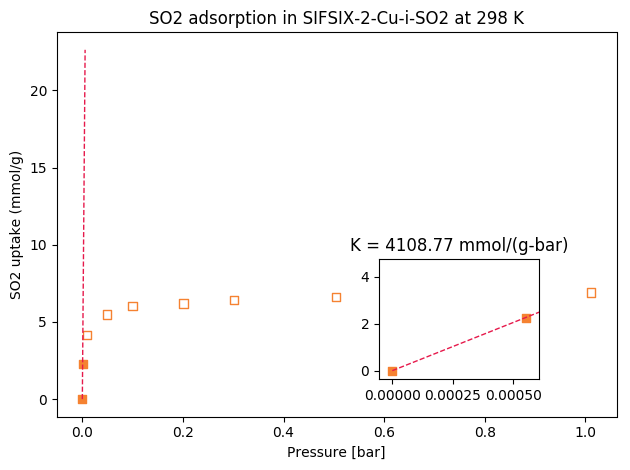

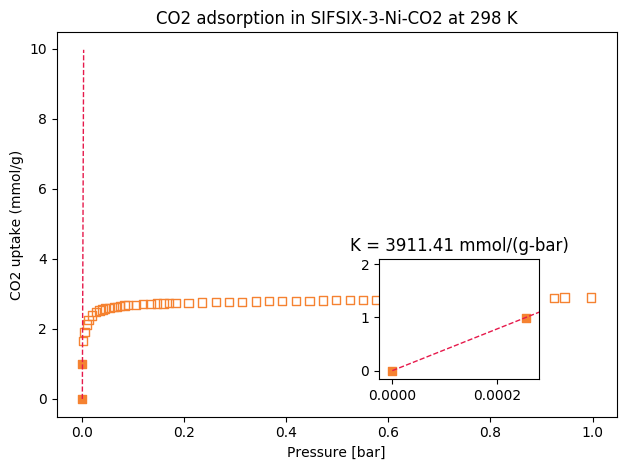

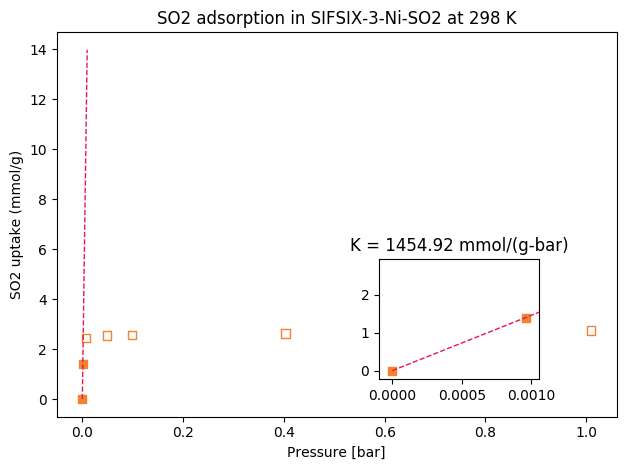

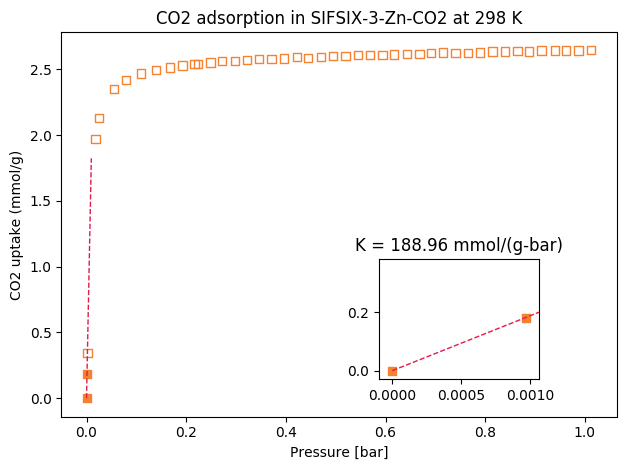

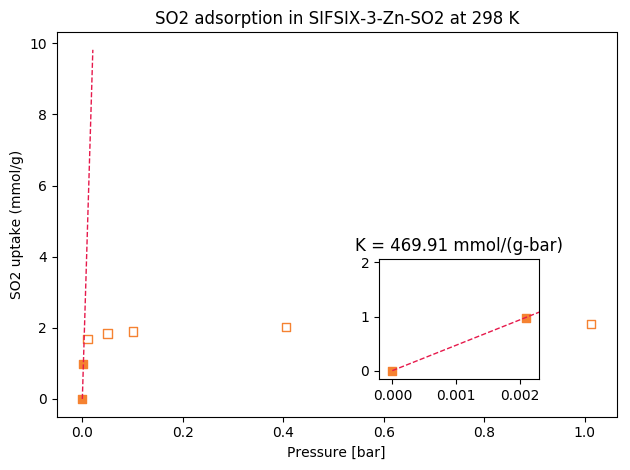

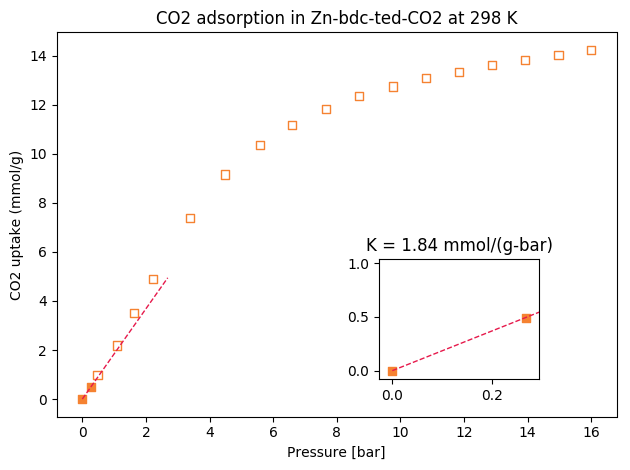

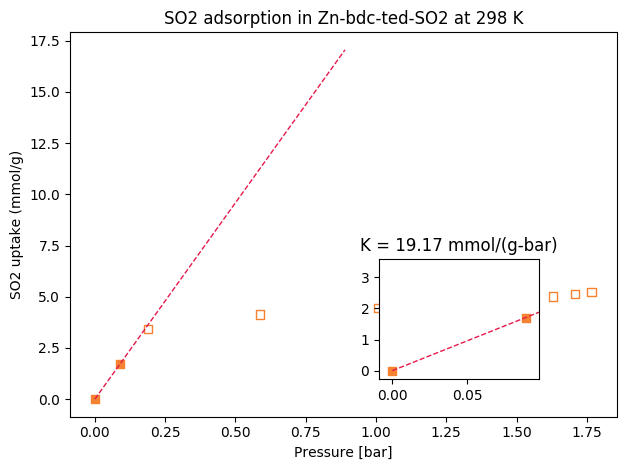

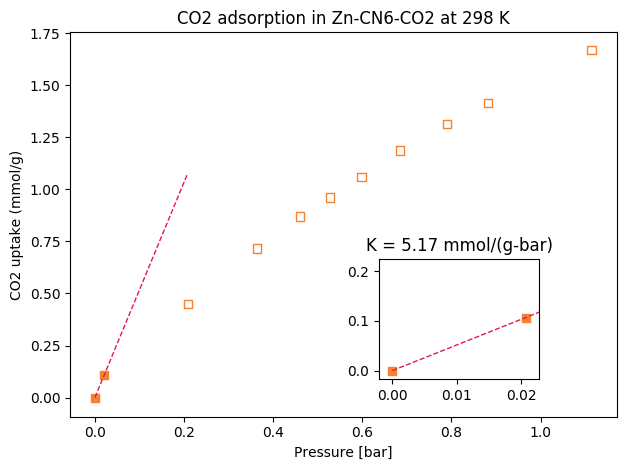

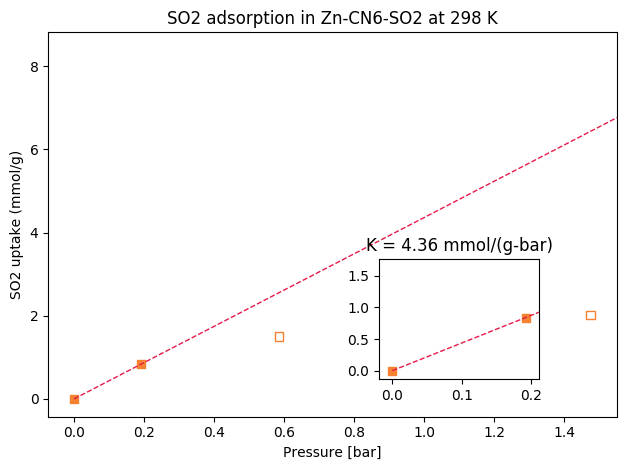

Zn-CN6-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g


In [18]:
for MOF in list_of_isotherms
#for MOF in ["MCM-41-water_298K.csv"]
    isotherm = read_and_convert(MOF)
    henry = fit_henry(isotherm, nb_pts_to_incl_in_fitting[MOF])
    mofstuff = split(MOF, "_")
    gas = split(mofstuff[1], "-")[end]
    temperature = split(mofstuff[2], ".")[1]
    mofname = mofstuff[1]

    fig = plt.figure()
    plt.xlabel("Pressure [bar]")
    labelstring = @sprintf("%s uptake (mmol/g)", gas)
    plt.ylabel(labelstring)
    plt.title(@sprintf("%s adsorption in %s at %d K",gas, mofname, parse(Int, temperature)))
    
    nb_pts = nb_pts_to_incl_in_fitting[MOF]
    plt.scatter(isotherm[1:nb_pts, 1], isotherm[1:nb_pts, 2], marker="s", color="#f58231")
    plt.scatter(isotherm[nb_pts+1:end, 1], isotherm[nb_pts+1:end, 2], marker="s", facecolor="none", edgecolor="#f58231")
    plt.plot([0, 10.0 * isotherm[1][nb_pts]], [0, 10.0 * isotherm[1][nb_pts] * henry], linestyle="--", color="#e6194b", linewidth=1)
    plt.xlim([-0.05*isotherm[1][end], isotherm[1][end]*1.05])
    #plt.xlim([-0.3, isotherm[1][end] + 0.3])
    
    #if isotherm[1][end] > 5
        # inset
        a = plt.axes([.6, .2, .25, .25])# , facecolor="C3")
        #P = range(0.0, stop=1.1 * dfs[gas][zeolite][Symbol("Pressure (bar)")][incl_nb_pts], length=100)
        plt.plot([0, 2.0 * isotherm[1][nb_pts]], [0, 2.0 * isotherm[1][nb_pts] * henry], linestyle="--", color="#e6194b", linewidth=1)
        plt.scatter(isotherm[1:nb_pts, 1], isotherm[1:nb_pts, 2], marker="s", color="#f58231")
        plt.xlim([-0.1*isotherm[1][nb_pts], isotherm[1][nb_pts]*1.1])
        plt.title(@sprintf("K = %.2f mmol/(g-bar)", henry))
    #end
    plt.tight_layout()
    plt.savefig("expt_" * gas * "_in_" * mofname * ".png", format="png", dpi=300)
    
end

In [26]:
open("CO2_henry_coefs_v2.csv", "w") do f
    @printf(f, "MOF,CO2_henry coefficient [mmol/(g-bar)],Temperature [K]\n")
    for MOF in list_of_isotherms
        isotherm = read_and_convert(MOF)
        henry = fit_henry(isotherm, nb_pts_to_incl_in_fitting[MOF])
        mofstuff = split(MOF, "_")
        println(mofstuff[1])
        temperature = split(mofstuff[2], ".")[1]
        gasname = split(mofstuff[1], "-")[end]
        mofname = mofstuff[1][1:end-4]
        if gasname == "CO2"
            @printf(f, "%s,%f,%d\n", mofname, henry, parse(Int64, temperature))
        end
    end
end

Working on file Co-CN6-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Co-CN6-CO2
Working on file Co-CN6-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Co-CN6-SO2
Working on file MFM-300-In-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
MFM-300-In-CO2
Working on file MFM-300-In-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
MFM-300-In-SO2
Working on file MFM600-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
MFM600-CO2
Working on file MFM600-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
MFM600-SO2
Working on file MFM601-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
MFM601-CO2
Working on file MFM601-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
MFM601-SO2
Working on file Ni-bdc-ted-CO2_298.csv
Pressure unit is already 

In [27]:
open("SO2_henry_coefs_v2.csv", "w") do f
    @printf(f, "MOF,SO2_henry coefficient [mmol/(g-bar)],Temperature [K]\n")
    for MOF in list_of_isotherms
        isotherm = read_and_convert(MOF)
        henry = fit_henry(isotherm, nb_pts_to_incl_in_fitting[MOF])
        mofstuff = split(MOF, "_")
        println(mofstuff[1])
        temperature = split(mofstuff[2], ".")[1]
        gasname = split(mofstuff[1], "-")[end]
        mofname = mofstuff[1][1:end-4]
        if gasname == "SO2"
            @printf(f, "%s,%f,%d\n", mofname, henry, parse(Int64, temperature))
        end
    end
end

Working on file Co-CN6-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Co-CN6-CO2
Working on file Co-CN6-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Co-CN6-SO2
Working on file MFM-300-In-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
MFM-300-In-CO2
Working on file MFM-300-In-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
MFM-300-In-SO2
Working on file MFM600-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
MFM600-CO2
Working on file MFM600-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
MFM600-SO2
Working on file MFM601-CO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
MFM601-CO2
Working on file MFM601-SO2_298.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
MFM601-SO2
Working on file Ni-bdc-ted-CO2_298.csv
Pressure unit is already 